## Introduction
In this notebook I present an implementation of the method of *Machine Learning-based Occupancy Estimation Using Multivariate Sensor Nodes* (Singh, Jain, Chaudhari, Garg, in *Communication, Computing, and Networking in Cyber Physical Systems 2018*). My purpose in doing this is, firstly, to increase my familiarity with techniues of machine learning, and secondly to demonstrate my knowledge for anyone who might be interested.

The original paper and the dataset used may be found on the UC Irvine ML repository at [https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation].

## The original work
The original paper presents an evaluation of different ML algorithms for estimating the number of occupants of a room using data from non-intrusive sensors. The dataset used was generated over four days in an office room equipped with sensors to measure temperature, light level, sound intensity, and CO<sub>2</sub> concentration, as well as a PIR sensor to detect motion. Measurements from these sensors were recorded every 30 seconds, together with the number of people in the room (via a sign-in/sign-out system). The final feature in the dataset is an estimate of the
slope of the CO<sub>2</sub> concentration (obtained from the CO<sub>2</sub> concentration data). See the paper for more detail on how the data was generated.

This data was then used to assess the performance of five different ML algorithms for estimating the number of people in the room from the sensor data: Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Random Forest (RF), and Support Vector Machine (SVM) with both linear and rbf kernels. Accuracy and F1 scores were obtained for these methods using 10-fold cross validation. Further, Principal Component Analysis (PCA) was used to reduce the dimension of the dataset, and the above algorithms were also applied to this principal component data.

## My implementation
I have attempted to implement the algorithms as described in the original paper in this notebook. However, I have not been able to fully implement some aspects due to the limited computational resources available to me. Full details are given below, but in summmary my personal computer is not able to run some of the SVM training algorithms in a reasonable timeframe and so I have compromised by running these algorithms on a sub-sample of the dataset.


### Dataset citation and license
The citation for the dataset used here is: Adarsh Pal Singh, Vivek Jain, Sachin Chaudhari, Frank Alexander Kraemer, Stefan Werner and Vishal Garg, "Machine Learning-Based Occupancy Estimation Using Multivariate Sensor Nodes," in 2018 IEEE Globecom Workshops (GC Wkshps), 2018. The dataset is used under a Creative Commons Attribution 4.0 International (CC BY 4.0) license (see the UC Irvine page above for more information).

In [1]:
import pandas as pd
import numpy as np
import itertools,time,datetime,multiprocessing

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown

# Part 1 - Preparing the data

First, we load the data. The feature column names are of the form Sn_xxx, where Sn is the name of the location in the room where the sensor was located (the locations were S1 to S7), and xxx is the type of sensor that produced the data (types are temperature, light level, sound level, CO<sub>2</sub> concentration, and PIR motion sensor, with
the estimate of the slope of the CO<sub>2</sub> concentration also included as a feature even though it was calculated from the CO<sub>2</sub> concentration). Note each location had only a subset of the sensor types.

In [2]:
# Load the data
data = pd.read_csv('Occupancy_Estimation.csv',parse_dates=[['Date', 'Time']])
display(data.columns)

# Check that the data is sorted by observation time
print(f"Data sorted: {data['Date_Time'].is_monotonic_increasing}")

Index(['Date_Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

Data sorted: True


The paper considers a range of different subsets of the full feature set, as well as components produced by PCA. We now generate these components. Note that data on light levels was not included in the data used as input for the PCA as light levels already gave a high level of predictive accuracy; see the paper for further details.

In [3]:
features_data = data.drop(['Date_Time','Room_Occupancy_Count',
                          'S1_Light','S2_Light','S3_Light','S4_Light'],axis=1)
X = features_data.to_numpy()
PCA_datasets = {}
PCA_min_comps, PCA_max_comps = 1,12
for n in range(PCA_min_comps, PCA_max_comps+1):
    pca = PCA(n_components=n)
    PCA_datasets[f"PCA_{n}"] = pca.fit_transform(X)

We now extract the various feature sets which we shall feed into our algorithms.

In [4]:
# First define the features sets containing data from only one type of sensor, by assigning to each feature set
# name a list of columns
feature_sets_colnames = {'Temp{1,2,3,4}':['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp'],
                'Light{1,2,3,4}':['S1_Light','S2_Light', 'S3_Light', 'S4_Light'],
                'Sound{1,2,3,4}':['S1_Sound','S2_Sound', 'S3_Sound', 'S4_Sound'],
                'PIR{6,7}':['S6_PIR', 'S7_PIR'],
                'CO2':['S5_CO2'],
                'Slope':['S5_CO2_Slope']}

# Next define the various feature sets which combine different types of data, and generate the appropriate list
# of column names from the existing feature sets
compound_feature_set_names = ['CO2, Slope',
                              'Temp{1,2,3,4}, CO2, Slope',
                              'Temp{1,2,3,4}, CO2, Slope, Sound{1,2,3,4}',
                              'Temp{1,2,3,4}, CO2, Slope, Sound{1,2,3,4}, PIR{6,7}',
                              'Temp{1,2,3,4}, CO2, Slope, Sound{1,2,3,4}, PIR{6,7}, Light{1,2,3,4}']
for cfsn in compound_feature_set_names:
    bits = cfsn.split(', ')
    feature_set = []
    for bit in bits:
        feature_set += feature_sets_colnames[bit]
    feature_sets_colnames[cfsn] = feature_set
    
# Store two particular feature set names for use in the final analysis
all_features_name = compound_feature_set_names[4]
all_features_no_lights_name = compound_feature_set_names[3]

# Use the lists of column names to generate numpy arrays, and add in the PCA arrays
feature_sets_data = {k:data[feature_sets_colnames[k]].to_numpy() for k in feature_sets_colnames}
feature_sets_data.update(PCA_datasets)

#Prepare a dictionary to store the scores for the various models and feature sets
feature_sets_to_scores = {fs_name:{} for fs_name in feature_sets_data}

#Extract the known classifications for our data
known_classifications = data['Room_Occupancy_Count'].to_numpy()

# Part 2 - Some useful functions
**model_run():** All of the models considered in the paper are assessed via 10-fold cross-validation to measure accuracy and f1 score, and model_run() packages this functionality conveniently. I have implemented the cross-validation myself rather than using the built-in functions from scikit-learn so that I can easily implement the method described in the paper, where for the SVM models we normalize each training set to have zero mean and unit standard deviation and then apply this same normalization to the test set. Note that as in the original paper the data is not shuffled prior to cross-validation since it is time-series data.

**run_timeout()** and its helper function **run_and_enqueue()** allow us to run functions with a timeout, so that the function will be killed if it runs too long. This will be use when doing the hyperparameter tuning for the SVM algorithms.

**print_update()** is a little function to allow for running code to give updates on its progress. I found this helpful while developing this notebook and so I have left it in. I left it turned on for the final run of the notebook, but I have deleted the output it produced as this output is no longer relevant after the notebook has run.

In [5]:
def model_run(estimator,X,y,normalize=False):  
    kf = KFold(n_splits=10)
    acc_scores = []
    f1_scores = []

    for train_index,test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if normalize:
            X_train_mean = X_train.mean(axis=0)
            X_train_stddev = X_train.std(axis=0)
            X_train = (X_train - X_train_mean)/X_train_stddev
            X_test = (X_test - X_train_mean)/X_train_stddev
        
        estimator.fit(X_train,y_train)
        y_pred = estimator.predict(X_test)
        acc = metrics.accuracy_score(y_test,y_pred)
        f1 = metrics.f1_score(y_test,y_pred,average='macro')
        
        acc_scores.append(acc)
        f1_scores.append(f1)
    
    # The return value is the pair [accuracy, f1 score], where the values are the averages over the cross-validation
    return [np.array(acc_scores).mean(),np.array(f1_scores).mean()]

# run_and_enqueue() is just a helper function for run_timeout()
def run_and_enqueue(func,args,kwargs,queue):
    res = func(*args,**kwargs)
    queue.put(res)

def run_timeout(func,args,kwargs,timeout):
    queue = multiprocessing.Queue()
    proc = multiprocessing.Process(target=run_and_enqueue, args=(func,args,kwargs,queue))
    proc.start()
    proc.join(timeout)
    if proc.is_alive():
        proc.kill()
        return False
    else:
        return queue.get()

# The implementation of print_update using a global variable is a bit crude but sufficient for our needs
print_update_on = True  #controls whether print_update() produces output
last_msg_len = 0
def print_update(msg,last=False):
    global last_msg_len
    if not print_update_on:
        return
    to_print = '\r'+(' '*last_msg_len)+'\r'+msg
    if not last:
        print(to_print,end='')
        last_msg_len = len(msg)
    else:
        print(to_print)
        last_msg_len

# Part 3 - Running the algorithms

## LDA and QDA
We run LDA and QDA on all of the feature sets

In [ ]:
XDA_models = [['LDA',LinearDiscriminantAnalysis()],['QDA',QuadraticDiscriminantAnalysis()]]
for feature_sets_data_item,model in itertools.product(feature_sets_data.items(),XDA_models):
    model_name,estimator = model
    feature_set_name,X = feature_sets_data_item
    print_update(f"{model_name}|{feature_set_name}") # print progress
    acc,f1 = model_run(estimator,X,known_classifications) # measure the performance...
    feature_sets_to_scores[feature_set_name][model_name] = [acc,f1] # ...and record it

## Random Forest
We run RF on all of the feature sets. As in the paper, we fix the number of trees in the forest at 30, and for each feature set and model we take the average accuracy and f1 score over 100 iterations

In [ ]:
model_name = 'RF'
estimator = RandomForestClassifier(n_estimators=30)
n_iterations = 100

for feature_set_name in feature_sets_data:
    X = feature_sets_data[feature_set_name]
    
    # run RF 100 times on the data, keeping a running sum of accuracy and f1
    acc,f1 = 0,0
    for i in range(0,n_iterations):
        print_update(f"{feature_set_name}: {i+1}") # print an update of which iteration we are on
        res = model_run(estimator,X,known_classifications)
        acc += res[0]
        f1 += res[1]
    print_update(f"{feature_set_name}: Done",last=True)

    # record the average scores
    acc = acc/n_iterations
    f1 = f1/n_iterations  
    feature_sets_to_scores[feature_set_name][model_name] = [acc,f1]

## Support Vector Machine
We next apply SVM classifiers with both linear and rbf kernels to our data. This is the point where I have been unable to perform a full replication of the paper's method due to the limited computational resources at my disposal. In the paper, each combination of kernel and feature set is run with different values of the penalty hyperparameter, which I will henceforth in accordance with convention and scikit-learn's notation call *C*. Unfortunately, some of the calculations with high values of C run for multiple hours on my system without finishing, and so I have implemented a strategy where only a small sub-sample of the dataset is used to tune the hyperparameter, and then in *some* cases the full data set is used to assess the performance of the algorithm with this tuned value.

**So note that this section is not a true recreation of the method in the paper**

The description of the implementation of the SVM models given in the paper is as follows

> In case of SVM, the training set features were normalized to have
zero mean and unit variance since the algorithm is scale-
variant. The normalization constants from the training set were
used to scale the testing set at each iteration of the cross
validation loop. Apart from linear SVM, we also evaluated the
results with RBF kernel to allow for non-linear classification
boundaries. The penalty hyperparameter was varied from 10<sup>−4</sup>
to 10<sup>4</sup> for each feature set and the best metric value is
reported.

I have interpreted this to mean that for each combination of model (i.e. SVM with linear kernel or SVM with rbf kernel) and feature set, accuracy and f1 score are calculated (via 10-fold cross-validation with normalization) for each *C* in $\{0.0001,0.001,0.01,0.1,1,10,100,1000,10000\}$ and the best accuracy and f1 score obtained are reported (i.e. the reported accuracy and f1 score may come from different *C* values).

My compromise implementation is as follows. For each combination of model and feature set, we first make a sub-sampling of the dataset by choosing every 100th record for non-PCA derived feature sets, or every 30th record for PCA-derived feature sets (see below for the logic behind this difference). We then calculate accuracy and f1 score for each *C* value in the set given above by 10-fold cross-validation with normalization using this sub-sampling. We repeat this sub-sampling and calculation a total of 10 times at different offsets into the data, average the scores over these 10 repetitions, and choose the *C* values which give the best values of these metrics. If these chosen *C* values are equal to or less than 100, we recalculate the metrics for these *C* values on the full dataset and report the accuracy or f1 score thus obtained, but if *C* is 1000 or 10000 then we just report the value from the sub-sampling. We make a record of which reported values were computed using just the small sample, so that we can mark these "suspect" values in the final analysis.

I have chosen different sub-sample factors for the PCA-derived and non-PCA-derived feature sets. This is tenable since we shall not be directly comparing the PCA-derived and non-PCA-derived feature sets in our final analysis. We want to use the largest possible sub-sample, and for the non-PCA-derived feature sets a 30-fold reduction in the size of the dataset produces acceptable running times. However, for the feature set with one principal component, the *C* = 10000 case runs for hours on my machine without terminating. Thus for the principal component feature sets it is necessary to choose a bigger reduction in dataset size, and 100-fold seems to work.

Another feature which I have had to implement to enable the code to run with the resources I have available is that, when we are performing the sub-sampling of the data to tune the hyperparameter *C*, we impose a time limit of 10 minutes on each calculation of accuracy and f1 score. If any calculation fails due to timeout, we ignore that sub-sampling and try another one instead.

The theory behind my approach is that (according to some brief reading) the running time of an SVM classifier is polynomial in the input size. The exact polynomial degree depending on the kernel and the value of *C*, but it seems that it is typically between 2 and 3 (i.e. between quadratic and cubic). Thus cutting the input size can dramatically cut the running time.

In [ ]:
C_values = [10**p for p in range(-4,5)]
SVC_models = [['SVM (linear)','linear'],['SVM (rbf)','rbf']]

SVC_best_C_vals = {}   # to store the C-values corresponding to the best accuracy and f1 scores
SVC_suspect_results = [] # to record which metric values are "suspect" (see above)

# parameters to keep run-time manageable
SVC_cutoff_C_val = 1000      # C value at-or-above which the full dataset won't be used at all
SVC_main_subset_factor = 30  # sampling factor for non-PCA-derived feature sets
SVC_PCA_subset_factor = 100  # sampling factor for PCA-derived feature sets
SVC_estimate_repeats = 10    # number of different offsets into the data to use when sub-sampling

for feature_sets_data_item,model in itertools.product(feature_sets_data.items(),SVC_models):
    model_name,kernel = model
    feature_set_name,X = feature_sets_data_item 
    if feature_set_name.startswith('PCA_'):
        subset_factor = SVC_PCA_subset_factor
    else:
        subset_factor = SVC_main_subset_factor
    
    # for each C value, estimate the accuracy and f1 scores via a 10-fold sub-sampling of the data
    sub_sample_scores = {C_val:[0,0] for C_val in C_values}
    for C_val in C_values:
        
        # try different offsets into the data until we have enough sub-samples
        offsets_done = 0
        offset = 0
        while (offset<subset_factor) and (offsets_done < SVC_estimate_repeats):
            X_subset = X[offset::subset_factor]
            known_classifications_subset = known_classifications[::subset_factor]
            print_update(f"{model_name}|{feature_set_name}: C={C_val} [small sample, offset={offset}, "+\
            f"offsets_done={offsets_done}]")
            estimator = SVC(C=C_val,kernel=kernel)
            res = run_timeout(model_run,(estimator,X_subset,known_classifications_subset),
                              {'normalize':True},600) # allow at most 10 minutes for each sub-sample
            if res != False:
                acc,f1 = res
                sub_sample_scores[C_val][0] += acc
                sub_sample_scores[C_val][1] += f1
                offsets_done += 1 
            offset += 1

        # average the scores over the number of sub-samples
        sub_sample_scores[C_val][0] /= offsets_done
        sub_sample_scores[C_val][1] /= offsets_done
        
    # find which C values produce the best accuracy and f1 score
    sub_sample_scores_triples = [[C_val]+sub_sample_scores[C_val] for C_val in C_values]
    sub_sample_scores_triples.sort(key = lambda P: P[1])
    best_acc_pair = [sub_sample_scores_triples[-1][0],sub_sample_scores_triples[-1][1]]
    sub_sample_scores_triples.sort(key = lambda P: P[2])
    best_f1_pair = [sub_sample_scores_triples[-1][0],sub_sample_scores_triples[-1][2]]
    best_C_vals_pair = [best_acc_pair[0],best_f1_pair[0]]
    SVC_best_C_vals[f"{model_name}|{feature_set_name}"] = best_C_vals_pair
  
    # now recalculate the accuracy and f1 scores produced by the chosen C values using the whole dataset
    # provided that the C values are small enough for the calculation to be viable
    C_val_to_do_full = [C_val for C_val in best_C_vals_pair if C_val < SVC_cutoff_C_val] 
    full_data_scores = {}
    for C_val in set(C_val_to_do_full):
        print_update(f"{model_name}|{feature_set_name}: C={C_val} [full data]")
        estimator = SVC(C=C_val,kernel=kernel)
        acc,f1 = model_run(estimator,X,known_classifications,normalize=True)
        full_data_scores[C_val] = [acc,f1]
    print_update(f"{model_name}|{feature_set_name}: Done",last=True)
    
    # record the best accuracy and f1 scores obtained in feature_sets_to_scores
    # while also recording if either score was obtained using just the small sample
    if best_acc_pair[0] in full_data_scores:
        best_acc_pair[1] = full_data_scores[best_acc_pair[0]][0]
    else:
        SVC_suspect_results.append([feature_set_name,model_name,'acc'])
    if best_f1_pair[0] in full_data_scores:
        best_f1_pair[1] = full_data_scores[best_f1_pair[0]][1]
    else:
        SVC_suspect_results.append([feature_set_name,model_name,'f1'])
    feature_sets_to_scores[feature_set_name][model_name] = [best_acc_pair[1],best_f1_pair[1]]

# Part 4 - Analysing the results

We now perform the same analysis of the results as in the original paper. We begin by recreating the paper's *Table II* with our data, with the additional feature of marking the scores for the SVM classifiers which were obtained using just the sub-sample of the data with an asterisk.

In [9]:
# Put the accuracy and f1 scores which we have obtained into a dataframe for display as a table
rows = []
model_names = ['LDA','QDA','SVM (linear)','SVM (rbf)','RF']
indices_to_star = {'SVM (linear)':[],'SVM (rbf)':[]}
i=0
for fs_name in feature_sets_to_scores:
    if fs_name.startswith('PCA_'):
        continue
    acc_row = [fs_name,'A']
    f1_row = [fs_name,'F1']
    for model_name in model_names :
        acc_row.append(feature_sets_to_scores[fs_name][model_name][0])
        f1_row.append(feature_sets_to_scores[fs_name][model_name][1])
        if [fs_name,model_name,'acc'] in SVC_suspect_results:
            indices_to_star[model_name].append(i)
        if [fs_name,model_name,'f1'] in SVC_suspect_results:
            indices_to_star[model_name].append(i+1)
    rows += [acc_row,f1_row]
    i+=2
results_df = pd.DataFrame(rows,columns=['Feature','Metric']+model_names)

# Do some formatting:
# (1) round the values in the table to 3 decimal places
# (2) convert the numerical values to strings (to enable the next step)
# (3) mark with an asterisk those results for SVM classifiers which were obtained using just a sub-sample
#     of the data
rounded_results_df = results_df.round(decimals=3)
for mn in model_names:
    rounded_results_df[mn] = rounded_results_df[mn].astype(str)
for k in indices_to_star:
    rounded_results_df.loc[indices_to_star[k],k] = \
    rounded_results_df.loc[indices_to_star[k],k].apply(lambda x: x+'*')

# Do some cosmetic improvements and display the table (I am sure that there are more elegant ways to do this
# using the features of pandas but this works well enough)
rounded_results_df['Feature'] = rounded_results_df['Feature'].apply(lambda x: x.replace(' ','\n'))
rounded_results_df = rounded_results_df.set_index(['Feature','Metric'])
display(Markdown('### Main Results (cf Table II from the paper)'))
display(HTML(rounded_results_df.to_html().replace("\\n","<br>")))

### Main Results (cf Table II from the paper)

Note that the two columns containing scores for the SVM models cannot be regarded as a true replication of the corresponding columns in the paper's  *Table II* since the choice of which *C* value to use when computing these scores was chosen by tuning on a small sub-sample of the data only. Further, the values in the table that are marked with an asterisk were themselves computed using only this small sub-sample and so should be regarded as rough approximations only.

Next, let us recreate the graph in the paper's *Fig. 5*, showing the performance of the PCA-derived datasets using f1 score.

PCA-reduced dataset F1 performance

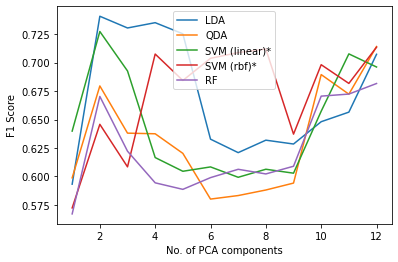

In [10]:
# Pull the PCA f1 scores out of the stored results and format them for graphing
model_f1_scores = {k:[] for k in model_names}
for n in range(PCA_min_comps, PCA_max_comps+1):
    scores = feature_sets_to_scores[f"PCA_{n}"]
    for k in scores:
        model_f1_scores[k].append(scores[k][1])

# Create the graph
display(Markdown('PCA-reduced dataset F1 performance'))
for k in model_f1_scores:
    label = k+'*' if 'SVM' in k else k
    plt.plot(list(range(PCA_min_comps, PCA_max_comps+1)),model_f1_scores[k],label=label)
plt.ylabel('F1 Score')
plt.xlabel('No. of PCA components')
plt.legend()
plt.show()

As above, I have marked the SVM plots with an asterisk to show that they are not true recreations of the results in the paper.

Finally, let us recreate the confusion matrices shown in *Table III* and *Table IV* in the paper. These tables in the paper show the confusion matrices of two cases of the SVM models trained using certain feature sets on the whole dataset. In particular
* *Table III* shows the confusion matrix for SVM with linear kernel on the complete feature set *except* the light
  data, with the best-performing (by f1 score, I *think*) *C* value
* *Table IV* shows the confusion matrix for SVM with rbf kernel on the complete feature set, with the best-performing (by f1 score, I *think*) *C* value.

Due to the sub-sampling method I have used for the SVM models, my confusion matrices are not a true replication of those in the paper. As with the table above, this is due to both the use of sub-sampling in tuning the hyperparameter, and also the use of the sub-sample to compute the matrix itself. I have used the sub-sampling method above for **all** *C*-values here, since for some reason fitting the models to the full dataset seems to run for many hours without finishing on my system, even for low *C*-values.

**Thus the matrices obtained here are not a true replication of those in the paper, but rather just illustrative estimates obtained from small sub-samples**

I think the original paper selected the best *C* value for these matrices by f1 score (although this is not explicitly stated in the paper), but I have included also the matrices for the *C* value with the best accuracy score in the case where this is different.

In [11]:
# define which models and feature sets we are interested in, and give a description of them
kernel_and_fs_names = [['linear',all_features_no_lights_name,'Linear SVM, all features except lights'],
                      ['rbf',all_features_name,'RBF SVM, all features']]

# Labels for the rows and columns of these matrices (note that the number of people in the room varied between
# 0 and 3)
matrix_labels_dict = {'index':[f"Actual {n}" for n in range(0,4)],
                      'columns':[f"Predicted {n}" for n in range(0,4)]}

def get_confusion_matrix(estimator,X,y):
    estimator.fit(X,y)
    return metrics.confusion_matrix(y,estimator.predict(X),labels=[0,1,2,3])

display(Markdown('**NB: all matrices obtained using small sample estimates**'))

for kernel,fs_name,descr in kernel_and_fs_names:
    
    # Pull out the best-performing C values
    C_vals = SVC_best_C_vals[f"SVM ({kernel})|{fs_name}"]
    # If best accuracy and f1 come from the same C value, we only want to compute the confusion
    # matrix once, but otherwise we want the confusion matrix for both accuracy and f1 score
    if C_vals[0] == C_vals[1]:
        loop_params = [['Accuracy and F1',0]]
    else:
        loop_params = [['Accuracy',0],['F1',1]]
        
    # Create and display the matrices. Depending on the result of the previous if-else, this loop
    # will either run once or twice
    for metric_name,ind in loop_params:
        X = feature_sets_data[fs_name]
        y = known_classifications
     
        # as above, perform repeated sub-smamplings of the data and take the average
        offsets_done = 0
        offset = 0
        CM_list = []
        while (offset<SVC_main_subset_factor) and (offsets_done < SVC_estimate_repeats):
            X_subset = X[offset::SVC_main_subset_factor]
            y_subset = y[offset::SVC_main_subset_factor]
            print_update(f"{descr} for {metric_name}: C={C_vals[ind]} [small sample, offset={offset}, "+\
            f"offsets_done={offsets_done}]")
            estimator = SVC(C=C_vals[ind],kernel=kernel)
            res = run_timeout(get_confusion_matrix,(estimator,X_subset,y_subset),{},600)
            if type(res) != type(False): # nasty hack!
                CM_list.append(res)
                offsets_done += 1 
            offset += 1
        CM = np.mean(CM_list, axis=0) # take the average of the confusion matrices obtained
        print_update("",last=True)

        # display the confusion matrix
        df_CM = pd.DataFrame(CM,**matrix_labels_dict)
        display(Markdown(f"{descr} (C = {C_vals[ind]}, best by {metric_name})"))
        display(df_CM)
        display(HTML('<hr/>'))

**NB: all matrices obtained using small sample estimates**

Linear SVM, all features except lights (C = 1, best by Accuracy)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,272.8,0.1,1.4,0.0
Actual 1,5.3,9.1,0.9,0.1
Actual 2,1.1,1.4,21.9,1.9
Actual 3,0.2,1.1,2.5,18.2


Linear SVM, all features except lights (C = 0.1, best by F1)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,271.9,0.0,1.8,0.5
Actual 1,10.6,2.5,2.5,0.1
Actual 2,2.2,0.9,21.0,2.1
Actual 3,0.7,1.3,3.1,16.8


RBF SVM, all features (C = 10000, best by Accuracy)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,274.2,0.0,0.0,0.0
Actual 1,0.0,15.7,0.0,0.0
Actual 2,0.0,0.0,26.2,0.0
Actual 3,0.3,0.0,0.0,21.6


RBF SVM, all features (C = 1, best by F1)

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,274.2,0.0,0.0,0.0
Actual 1,0.0,15.4,0.3,0.0
Actual 2,0.0,0.1,24.5,1.6
Actual 3,6.0,0.0,1.3,14.6
